In [3]:
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.signal import hilbert
from scipy.signal.windows import tukey 
import numpy as np
import vectorised_hf as vhf

# Load just the waveform from the data file
data = scipy.io.loadmat('data/ultrasound_reflection_data.mat', variable_names=['__header__', '__version__', '__globals__', 'elementPositions', 'samplingFrequency', 'soundSpeed','waveform', 'rcvData'])
waveform = data['waveform']
print(type(data))
print (data.keys())
folder_path = 'data'

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'elementPositions', 'rcvData', 'samplingFrequency', 'soundSpeed', 'waveform'])


(2560,)
256.0
256.0
167772160
(10000, 1)
(1, 256)


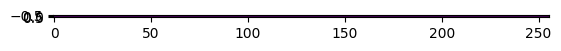

In [5]:
# Extract the numpy arrays from the dictionary using their variable names
waveform = data['waveform']
samplingFrequency = data['samplingFrequency']
elementPositions = data['elementPositions']
soundSpeed = data['soundSpeed']
rcvData = data['rcvData']

Ntx, Nrx, Nt = rcvData.shape
rcvData2D = rcvData.reshape(Ntx*Nrx, Nt)
winData2D = vhf.tukey_vectorised(rcvData2D,  alpha=0.1, noise_Length=300)
test_env = vhf.envelope_detection(winData2D)


dx = 0.001  # Grid spacing
Lx = 0.1    # Size of the grid
speedOfSound = 1540  # Speed of sound in m/s (typical for soft tissues)

# Create imaging vector
Xp, Yp = vhf.createImagingVector(dx, Lx)

# Detector coordinates (example values)
Xd = elementPositions[:,0]  # X coordinates of detectors
Yd = elementPositions[:,1]  # Y coordinates of detectors

# Xd, Xp, Yd and Yp are in 1D, this means that the function cannot run, since they don't have an overlapping dimension to be multipled by
# The following code makes the 'points' 2D and transposes the matrices so that they are in the right row to column order, before running the distance map function
Xd2D = Xd.reshape(-1,1)
Xp2D = Xp.reshape(-1,1)
Yd2D = Yd.reshape(-1,1)
Yp2D = Yp.reshape(-1,1)
Yd2DT = Yd2D.T
Xd2dT = Xd2D.T
print(Xp2D.shape)
print(Xd2dT.shape)
# Calculate distance map
distanceMap = vhf.calculateDistanceMap(Xd2dT, Yd2DT, Xp2D, Yp2D)
plt.imshow(distanceMap)
# plt.set_aspect('equal','box'), figure out how to draw this correctly
# Convert distance map to time map
timeMap = vhf.timeMap(distanceMap, speedOfSound)

# Initialise accumulator
accumulator = 0

accumulated_values = np.zeros(Xd2dT.shape)

# Plot X and Y using plt.imshow
plt.imshow(accumulated_values)

In [9]:
for Rx in range (255):
    # Loop over all the receivers, with only 1 transmitter, the pixel has been vectorised and will not be looped over
    accumulator = 0
    #  Have a 'time' from the transmitter to the pixel, then the pixel to the receiver for the total time
    T1 = timeMap[:,0]
    T2 = timeMap[:,Rx] 
    total_time = (T1 + T2).reshape(-1,1)
    total_time = total_time.reshape(-1,1)
    print(T1.shape)
    print(T2.shape)
    print(total_time)
    # Convert travel time to sample index
    sample_index = vhf.time_to_sample_index(total_time, samplingFrequency)
    print(sample_index.shape)

(10000,)
(10000,)
[[0.00021307]
 [0.00021283]
 [0.0002126 ]
 ...
 [0.00011823]
 [0.00011918]
 [0.00012014]]


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:


total_pixels = X.shape[0] * X.shape[1]
current_pixel = 0

for pixel_row in range(X.shape[0]):
    for pixel_col in range(X.shape[1]):
        accumulator = 0
        Xp = X[pixel_row, pixel_col]
        Yp = Y[pixel_row, pixel_col]
        # Check if elementPositions has the correct shape
        if elementPositions.shape !=(2,256):
            raise ValueError('elementPositions shape is not (2,256)')

        # Loop over all transmitters and receivers
        for Tx in [0]: 
            for Rx in range(256):  
                # Check if Tx and Rx are in range
                if Tx >= elementPositions.shape[1] or Rx >= elementPositions.shape[1]:
                    raise IndexError('Tx or Rx index out of range')
                x = vhf.accumulate_signal(Tx, Rx, Xp, Yp, elementPositions, soundSpeed, samplingFrequency, rcvData) # Not sure how to include processed data, 
                accumulator += x                                                            # since the 3d matrix is embedded back into the accumulate function, instead of the pre processed vectorisation function
        accumulated_values[pixel_row, pixel_col] = accumulator
        # Update progress
        current_pixel += 1
        percentage_completed = (current_pixel / total_pixels) * 100
        print(f"{percentage_completed:.2f}%", end='\r') # prints to 2dp, with a return